# 1) Preliminary step

## Import packages and dependencies

In [191]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.sparse.linalg import LinearOperator
import os
import importlib
from pathlib import Path
import scipy.io as sio
from scipy.signal import convolve2d
from scipy.ndimage import convolve
import scipy.stats
import cv2
from PIL import Image
from skimage import io
import plotly.graph_objects as go
import tifffile

DIRECTORY = os.path.abspath('')
os.chdir(DIRECTORY)

from Tools.PSNR import PSNR
from Deblurring.Algortihm.Penalized_MMS_heteroscedastic import P_MMS
from Deblurring.Operators.gradient_operator import generate_G
from Deblurring.Operators.PSF_operator import generate_blur
from Tools.noise_estimation import *

## Load image and select zone of interest 

In [192]:
# Load observed image (blurred + noisy)
path = "/home/julin/Documents/MPM_results/19/values/"
y_bar = np.load(path+'im.npy')[:-1, :-1, :-1]
# Normalize y_bar
y_max = y_bar.max()
y_bar = y_bar / y_max 

print(y_bar.shape)
# Zone of interest
n1_min = 0 
n1_max = y_bar.shape[0]
n2_min = 0
n2_max = y_bar.shape[1]
n3_min = 0
n3_max = y_bar.shape[2]
y = np.copy(y_bar)

# Sizes of the problem
n1, n2, n3 = y.shape
N = n1 * n2 * n3
print(n1, n2, n3)

(14, 14, 14)
14 14 14


## Show image

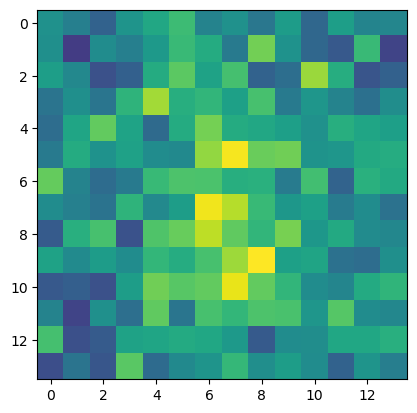

In [193]:
# Check that the slices of y_bar look ok
plt.figure()
plt.imshow(y[:,y.shape[1]//2,:], vmin=0)
plt.show()

# 2) Estimate noise parameters and prepare rescaling matrix

**Pour Jaj :** dans cette partie on estime le niveau de bruit. On fait l'hypothèse d'un bruit de Poisson qu'on approxime par un bruit Gaussien dit "heteroscedastique" (i.e. de variance qui varie avec l'intensité du pixel). Si tu veux plus d'info tu peux regarder l'article qu'on est en train d'écrire avec Claire (je te l'avais envoyé ?).
En gros 
$$ y = Hx + N(0, a Hx + b)$$
avec $a$ et $b$ deux constantes à determiner. 

Deux possibilités pour toi :
1) Estimer les paramètres $a$ et $b$ en executant le code ci-dessous

2) Fixer $a = 0$ et $b = \sigma^2$

Tant que tu travailles sur des données simulées j'opterais pour 2).

err =  1
err =  0.00023890861039370102
err =  3.4384116563279145e-05
err =  7.42010557315675e-06
err =  3.087286507848729e-06
err =  1.532270150343283e-06
err =  1.1184710667296624e-06
err =  1.1042775816569957e-06
err =  7.783705415383417e-07
err =  5.225617510622583e-07
err =  3.5890720950749414e-07
err =  2.0709953232544921e-07
err =  8.41602359793732e-08
err =  6.676995521997901e-08
err =  4.6426028294178e-08
err =  5.322548821546898e-08
err =  3.4404881950388187e-08
err =  3.2250027993198415e-08
err =  2.3363780426934218e-08
err =  4.161358970470241e-08


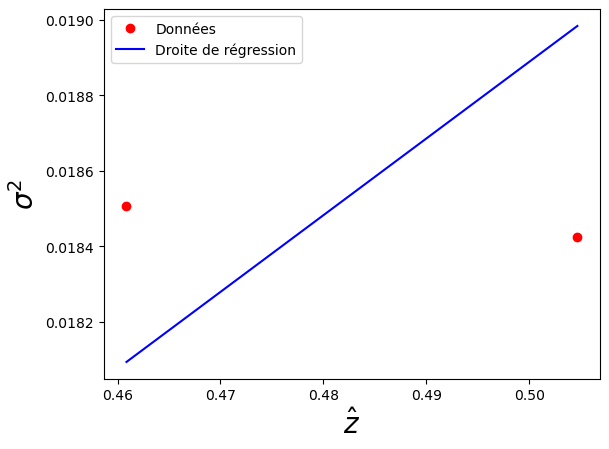

In [194]:
def estimate_params(y, params=None, plot_regression=False):
    if params is not None:
        n3_min, n3_max, z_init, z_inter = params
        im = y[:, :, n3_min : n3_max]
    else :
        im = y

    im_conv = blur(im, im.shape)

    xq, list_S, d, r = LM_quantifier(im_conv[:, :, :], 8)
    
    list_var = []
    list_I = []
    for S in list_S:
        n = np.sum(S)
        I = np.sum(S*im)/n
        list_I.append(I)
        list_var.append(1/(n-1) * np.sum((S*(im - I))**2))

    a, b = scipy.stats.linregress(list_I[:], list_var[:])[:2]
    
    if plot_regression == True:
        plt.figure()
        plt.plot(list_I[:-1], list_var[:-1], 'ro', label='Données')
        plt.plot(list_I[:-1], a * np.array(list_I[:-1]) + b, 'b-', label="Droite de régression")
        plt.xlabel(r'$\hat{z}$', fontsize=20)
        plt.ylabel(r'$\sigma^2$', fontsize=20)
        plt.legend()
        plt.show()
    
    return a, b

a, b  = estimate_params(y, plot_regression=True)

In [195]:
print("Estimated parameters:")
print("a = ", a)
print("b = ", b)

a = 0
b = 0.3**2/y_max**2


print("Estimated parameters:")
print("a = ", a)
print("b = ", b)
print("var = ", np.var(y[:4, :4, :4]))
print("y_max = ", y_max)

Estimated parameters:
a =  0.020317649149140523
b =  0.008730150691816515
Estimated parameters:
a =  0
b =  0.019049844361331465
var =  0.019964385585763588
y_max =  2.1735795471068555


# 3) Restoration

## Load PSF kernel

In [196]:
h = np.load(path+"ktrue.npy")
print(h.shape)
print((n1, n2, n3))
# define LinearOperator x --> h * x
H = generate_blur(h, (n1, n2, n3))

(15, 15, 15)
(14, 14, 14)


## Set parameters of the restoration algorithm

In [197]:
x_0 = np.copy(y)           # initialization 
delta = 0.1                # parameter in the TV regularization 
eta = 1                # parameter on the constraint. Should always be close to 1 !
x_min = 0                  # minimum pixel value in the restored image
x_max = 1                  # maximum pixel value in the restored image
res = np.array((1, 1, 1))/10    # resolution
max_iter = 1000            # maximum number of iteration of the algorithm
tolerance = 2*1e-05*N    # for stopping criterion
noise_params = (a, b)

## Set scaling matrix D

In [198]:
# y_conv =  blur(y, y.shape, KERNEL_SIZE=15, sigma=0.2)
D_scale = np.ones(N) / np.sqrt(abs(b))

## Run algorithm 

**Pour Jaj**:
L'algo est constitué de deux algos embriqués l'un dans l'autre. Quand on execute l'algo, il y a les itérations affichées. 

"iter" (en minuscule) --> algo intérieur

"ITER" (en majuscule) --> algo exterieur

C'est pas une idée incroyable je sais, il faudra que je change cela un jour. Mon critère d'arret porte sur le truc qui s'appelle "criterion" dans l'affichage. Ici il correspond à la différence entre deux itérées de l'algo exterieur. Mais entre nous ce n'est pas idéal. 

Il y a beaucoup de quantités affichées : 
- Psi : fonction de régularisation
- R1 : fonction de pénalisation pour la contrainte 1 (qui est que les pixels doivent être entre 0 et 1)
- R2 : fonction de pénalisation pour la contrainte 2 (qui porte sur le terme d'attache aux données, et qui est controlée par le paramètre eta)


In [199]:
x_opt =  P_MMS(np.copy(y), H, delta, eta, x_0, np.copy(y), x_min, x_max, res, noise_params, D_scale, max_iter, tolerance)

iter = 0, error = 968.4679504035302, PSNR = 18.39, Psi=5453.207103846602, R1 = 0.0, R2 = 0.0
iter = 20, error = 193.07888871152065, PSNR = 11.22, Psi=1960.2977622782212, R1 = 1.2544751292862136e-07, R2 = 2382.650884699342
iter = 40, error = 85.54123318097581, PSNR = 8.21, Psi=1232.494269451329, R1 = 0.0, R2 = 8959.13613736473
iter = 60, error = 17.220643668578777, PSNR = 7.62, Psi=1085.6366034201442, R1 = 0.0, R2 = 11260.317541791992
iter = 80, error = 2.0923277842099606, PSNR = 7.53, Psi=1065.9607502543433, R1 = 0.0, R2 = 11652.328487523966
ITER = 1, GAMMA = [0.08944272 0.04698476], EPS = 2.128350, criterion = 11661.706311521304
--------------------

iter = 0, error = 188.64347860283456, PSNR = 8.53, Psi=1065.7058848973172, R1 = 0.0, R2 = 11657.589320819528
iter = 20, error = 25.944610756765723, PSNR = 11.84, Psi=1978.5011856741744, R1 = 0.0, R2 = 2047.1080630531449
iter = 40, error = 2.8828350871796498, PSNR = 11.58, Psi=1917.5072163248801, R1 = 0.0, R2 = 2356.0368481625005
iter = 60

iter = 20, error = 0.04629996662862999, PSNR = 16.90, Psi=3185.64793534608, R1 = 0.0, R2 = 4.371429062280043
ITER = 25, GAMMA = [11.18033989 21.28349806], EPS = 0.046557, criterion = 4.374138188804071
--------------------

iter = 0, error = 0.6803028951661667, PSNR = 16.91, Psi=3193.6916089709666, R1 = 0.0, R2 = 4.009665914003839
iter = 20, error = 0.044606161610184956, PSNR = 16.91, Psi=3194.143315452976, R1 = 0.0, R2 = 3.9896353598052263
ITER = 26, GAMMA = [11.85782442 22.93012134], EPS = 0.045698, criterion = 3.9921997349652596
--------------------

iter = 0, error = 0.633955294281609, PSNR = 16.93, Psi=3201.7997051016973, R1 = 0.0, R2 = 3.6693898676201306
iter = 20, error = 0.041962121650106786, PSNR = 16.93, Psi=3202.2120465761454, R1 = 0.0, R2 = 3.6523625516814837
ITER = 27, GAMMA = [12.54846604 24.63474911], EPS = 0.044886, criterion = 3.654794643081521
--------------------

iter = 0, error = 0.5925856157209716, PSNR = 16.94, Psi=3209.5132448484546, R1 = 0.0, R2 = 3.367578723239

ITER = 53, GAMMA = [34.51109966 88.73217846], EPS = 0.032582, criterion = 0.6718446190932954
--------------------

iter = 0, error = 0.15262792630179342, PSNR = 17.14, Psi=3332.6135534944506, R1 = 0.0, R2 = 0.6381068004171498
ITER = 54, GAMMA = [35.49242173 91.94013464], EPS = 0.032294, criterion = 0.6382837053420711
--------------------

iter = 0, error = 0.14292754922421652, PSNR = 17.15, Psi=3335.567042625671, R1 = 0.0, R2 = 0.6065814243068096
ITER = 55, GAMMA = [36.48287269 95.20200651], EPS = 0.032014, criterion = 0.6068090828109617
--------------------

iter = 0, error = 0.136806368548562, PSNR = 17.15, Psi=3338.4356123066177, R1 = 0.0, R2 = 0.5770052035427637
ITER = 56, GAMMA = [37.48236919 98.5176952 ], EPS = 0.031741, criterion = 0.5772649933620144
--------------------

iter = 0, error = 0.13108270273700187, PSNR = 17.16, Psi=3341.22378580711, R1 = 0.0, R2 = 0.5492217843806001
ITER = 57, GAMMA = [ 38.49083008 101.88710385], EPS = 0.031475, criterion = 0.5495154135271294
------

ITER = 89, GAMMA = [ 75.09828227 237.57350465], EPS = 0.025471, criterion = 0.14628156350420954
--------------------

iter = 0, error = 0.0529007716035108, PSNR = 17.23, Psi=3402.0630263017265, R1 = 0.0, R2 = 0.14090996538269593
ITER = 90, GAMMA = [ 76.36753237 242.6709329 ], EPS = 0.025336, criterion = 0.14122138343629206
--------------------

iter = 0, error = 0.04777570425760879, PSNR = 17.23, Psi=3403.25631307931, R1 = 0.0, R2 = 0.13606739482577931
ITER = 91, GAMMA = [ 77.64385359 247.81959173], EPS = 0.025204, criterion = 0.13637838735033966
--------------------

iter = 0, error = 0.04816925972861588, PSNR = 17.23, Psi=3404.4214506413987, R1 = 0.0, R2 = 0.13143635370720283
ITER = 92, GAMMA = [ 78.92720697 253.01942458], EPS = 0.025073, criterion = 0.1317413433965942
--------------------

iter = 0, error = 0.049466720698466936, PSNR = 17.23, Psi=3405.560745981251, R1 = 0.0, R2 = 0.12700020581842741
ITER = 93, GAMMA = [ 80.21755419 258.27037553], EPS = 0.024945, criterion = 0.127297

## Display restored image and save to eps file 

In [200]:
x_opt_deblurred = x_opt * y_max

(15, 15, 15)
(15, 15, 15)


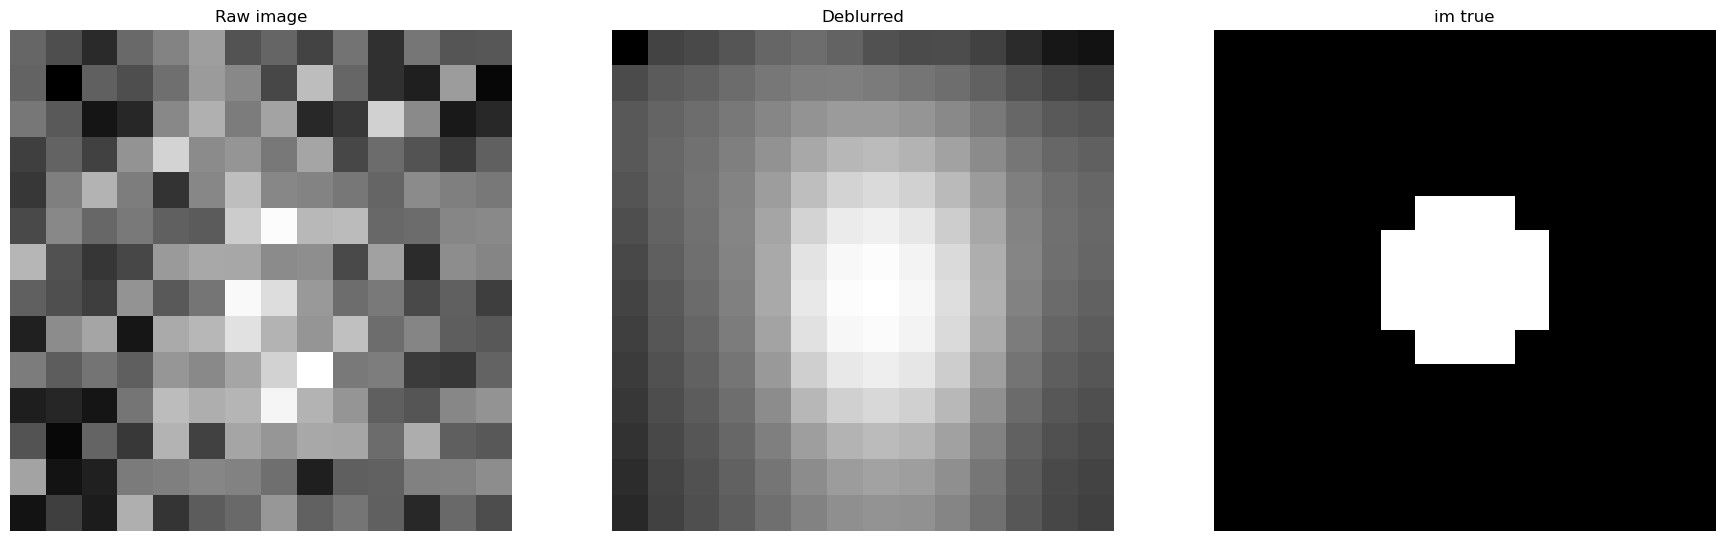

0.4770036107394132

In [211]:
from scipy.signal import convolve
p = np.load(path+"p.npy")
i = 0
plt.figure(figsize=(22,10))

plt.subplot(1, 3, 1)
plt.imshow(y[:,y.shape[1]//2,:], cmap="gray")
plt.axis('off')
plt.title(r'Raw image')

plt.subplot(1, 3, 2)
plt.imshow(x_opt_deblurred[:,y.shape[1]//2,:], cmap="gray")
plt.axis('off')
plt.title(r'Deblurred')

print(p.shape)
print(h.shape)
plt.subplot(1, 3, 3)
plt.imshow(p[:,p.shape[1]//2, :], cmap="gray")
plt.axis('off')
plt.title(r'im true')


plt.show()

np.var(y * y_max**2)

In [202]:
im_restored =  x_opt_deblurred[:,:,:]

tifffile.imsave('Data/muscle_gdf8/Results/im_restored_delta{}_eta{}.tif'.format(delta, eta),test.transpose(2, 0, 1))
tifffile.imsave('Data/muscle_gdf8/Results/im_brute.tif',y.transpose(2, 0, 1))

NameError: name 'test' is not defined